In [1]:
!git clone https://github.com/Jacobiano/morpholayers.git

Cloning into 'morpholayers'...
remote: Enumerating objects: 266, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 266 (delta 15), reused 20 (delta 11), pack-reused 221
Receiving objects: 100% (266/266), 125.70 KiB | 2.33 MiB/s, done.
Resolving deltas: 100% (152/152), done.


In [2]:
from imageio import imread
from matplotlib import pyplot as plt
import numpy as np
import numpy.matlib
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras import backend as K
from morpholayers.layers import Dilation2D, Erosion2D, Opening2D, Closing2D, Gradient2D
from morpholayers.initializers import Quadratic, SEinitializer
from morpholayers.constraints import SEconstraint
from morpholayers.constraints import NonPositiveExtensive

## Learning a dilation structuring element by adjunction

Load an image.

In [5]:
imCol = imread('imageio:chelsea.png')
imCat = imCol[:,:,0]

<ipython-input-5-d81d77f1c627>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imCol = imread('imageio:chelsea.png')


Imageio: 'chelsea.png' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/images/chelsea.png (216 kB)
Downloading: 8192/221294 bytes (3.7%)221294/221294 bytes (100.0%)
  Done
File saved as /root/.imageio/images/chelsea.png.


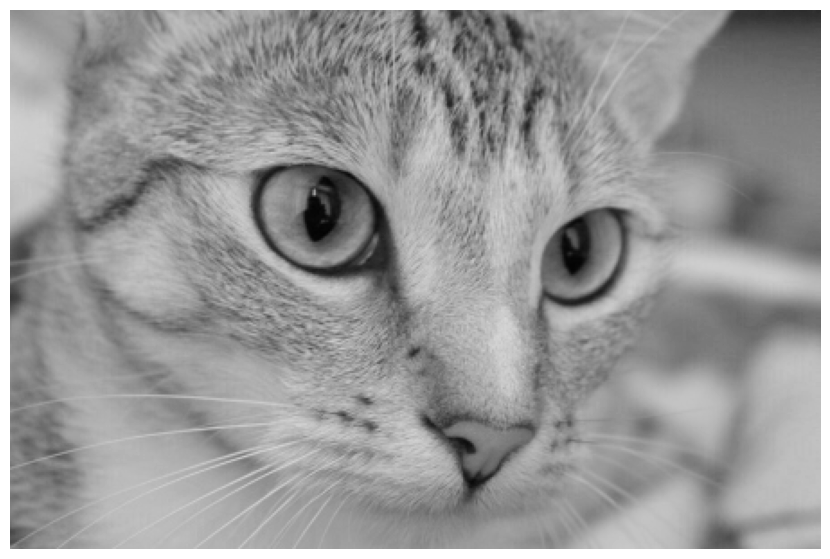

In [6]:
plt.figure(figsize=(15,7))
plt.imshow(imCat, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

Function to create structuring elements.

In [7]:
def mkSE(p, se_type):
    K = -255*np.ones((2*p+1, 2*p+1))
    if se_type == 'cross':
        K[p,:] = 0
        K[:,p] = 0
    if se_type == 'half_cross':
        K[p, p:] = 0
        K[p:,p] = 0
    if se_type == 'x-shaped':
        for i in range(2*p+1):
            K[i,i] = 0
            K[i,2*p - i] = 0
    if se_type == 'diag1':
        for i in range(2*p+1):
            K[i,2*p - i] = 0
    if se_type == 'diag2':
        for i in range(2*p+1):
            K[i,i] = 0
    if se_type == 'quad':
        lambd = 2*p
        for i in range(2*p+1):
            for j in range(2*p+1):
                K[i, j] = int(np.round(-0.5*255*((i-p)**2+(j-p)**2)/lambd**2))
    return K

Let's first try a $3\times 3$ cross structuring element (that is, $p=1$ and hence $2p+1 = 3$).

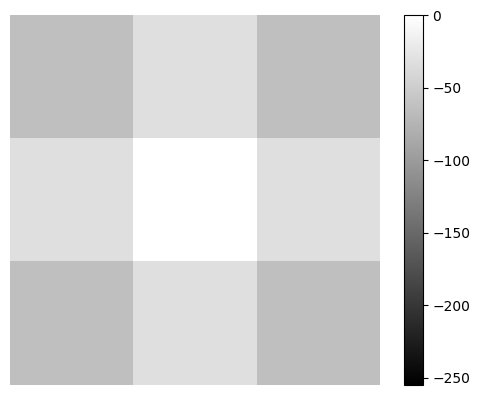

In [8]:
p = 1
SE_id = 'quad'#'diag2' #'diag1' #'x-shaped' # cross #'half_cross' #'quad'
SE = mkSE(p, SE_id)
plt.figure()
plt.imshow(SE,cmap='gray',vmax=0,vmin=-255)
plt.colorbar()
plt.axis('off')
plt.show()

The following functions implement the learning setting presented in the course:
- reshape the $M\times N$ image as a matrix $\tilde{X}$ containing $M\cdot N$ rows and $(2p+1)^2$ columns (each row $i$ is the reshaped $(2p+1)^2$ neighbourhood of pixel $i$.)
- the $(2p+1)\times (2p+1)$ structuring element is reshaped as a $(2p+1)^2$ column $W$
- the dilation is the max-plus matrix product $\tilde{X}.W$
- the fuction DilMaxPlus is an additional layer that does all the reshaping to take as input an image and a square structuring element, and return an image.

In [9]:
def block_reshape(im_in, p):
    m = im_in.shape[0]
    n = im_in.shape[1]
    im_shape = m*n
    im_padded = np.pad(im_in, ((p, p), (p, p)), mode='symmetric')
    X = np.zeros((im_shape, (2*p+1)**2))
    for i in range(m):
        for j in range(n):
            w = im_padded[i:i+2*p+1, j:j+2*p+1]
            w = np.reshape(np.transpose(w), ((2*p+1)**2))
            X[m*j+i, :] = w
    return X

In [10]:
def dil_max_plus(X, W):
    X_plus_W = X + np.matlib.repmat(np.transpose(W), X.shape[0], 1)
    return X_plus_W.max(axis = 1)

In [11]:
def DilMaxPlus(im_input, SE):
    M =im_input.shape[0]
    N =im_input.shape[1]
    p = int((SE.shape[0]-1)/2)
    SECol = np.reshape(np.transpose(SE), ((2*p+1)**2,1))
    imBlock = block_reshape(im_input, p)
    resColumn = dil_max_plus(imBlock, SECol)
    im_res = np.reshape(np.transpose(resColumn), (M, N), 'F')
    return im_res

In [12]:
catDil = DilMaxPlus(imCat, SE)

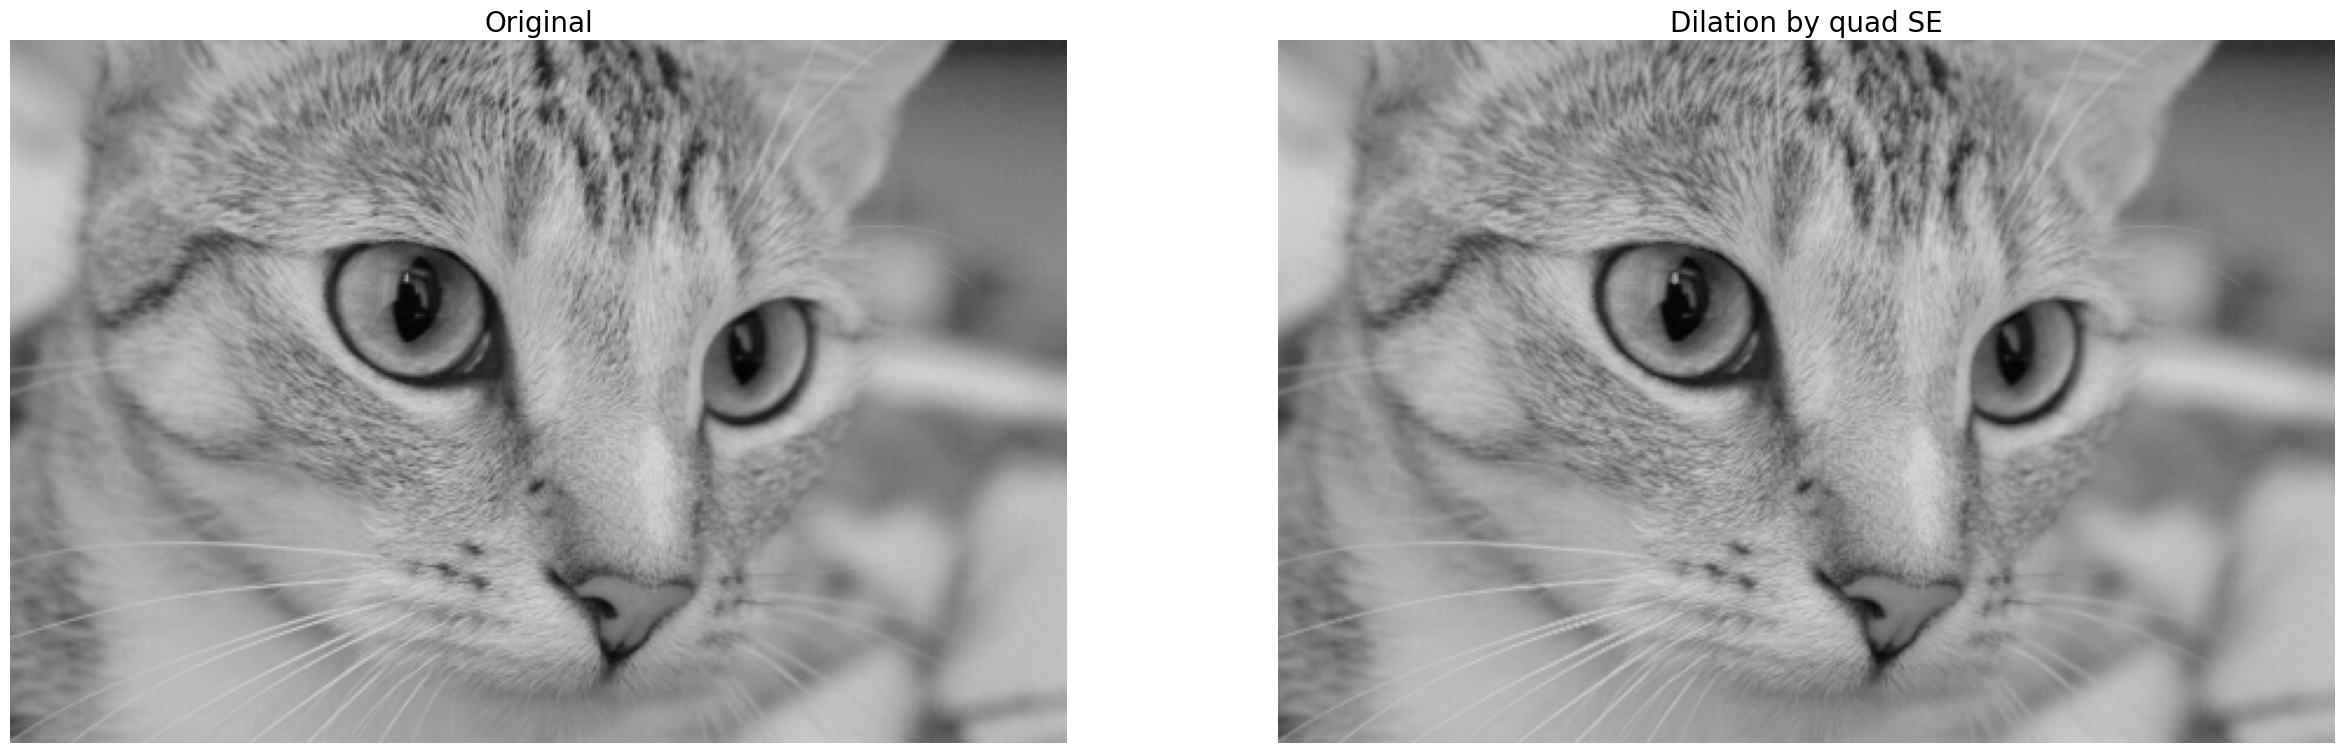

In [13]:
plt.figure(figsize=(30,12))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(imCat, cmap='gray', vmin=0, vmax=255)
plt.title('Original', fontsize=20)
plt.subplot(1,2,2)
plt.imshow(catDil, cmap='gray', vmin=0, vmax=255)
plt.title('Dilation by '+SE_id+' SE', fontsize=20)
plt.axis('off')
plt.show()

Reshape output image into a column vector of size $m\cdot n$:

In [14]:
m,n = catDil.shape
Y = np.reshape(catDil, (m*n,1), 'F')
print(Y.shape)

(135300, 1)


Define the erosion adjoint to the max-plus dilation:

In [15]:
def erod_min_plus(X, W):
    X_plus_W = X + np.matlib.repmat(np.transpose(W), X.shape[0], 1)
    return X_plus_W.min(axis = 1)

Reshape input image into a matrix $X$ of size $(m\cdot n) \times (2p+1)^2$:

In [16]:
X = block_reshape(imCat, p)
print(X.shape)

(135300, 9)


Define $X^* = -\tilde{X}^T$ and apply the adjoint erosion to recover the structuring element: $\hat{W} = \varepsilon_{X^*}(Y)$.

In [17]:
X_star = -np.transpose(X)
What = erod_min_plus(X_star, Y)
What = np.reshape(What, (2*p+1,2*p+1), 'F')
print(What)

[[-64. -32. -64.]
 [-32.   0. -32.]
 [-64. -32. -64.]]


Compare original and recovered structuring elements.

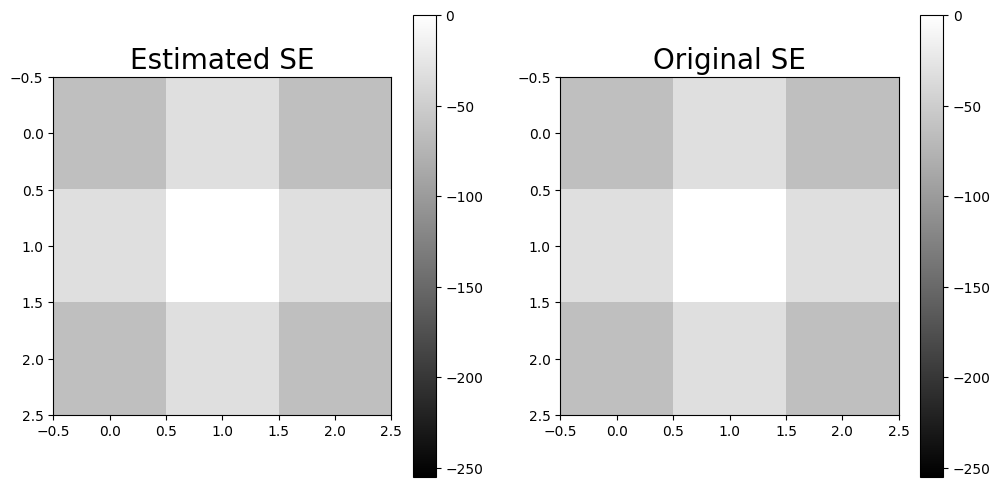

In [18]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(What, cmap = 'gray',vmax=0,vmin=-255)
plt.title('Estimated SE', fontsize=20)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(SE,cmap='gray',vmax=0,vmin=-255)
plt.title('Original SE', fontsize=20)
plt.colorbar()
plt.show()

Compute the dilation of input image with the recovered structuring element and compare with original dilation.

In [19]:
catDilEstSE = DilMaxPlus(imCat, What)

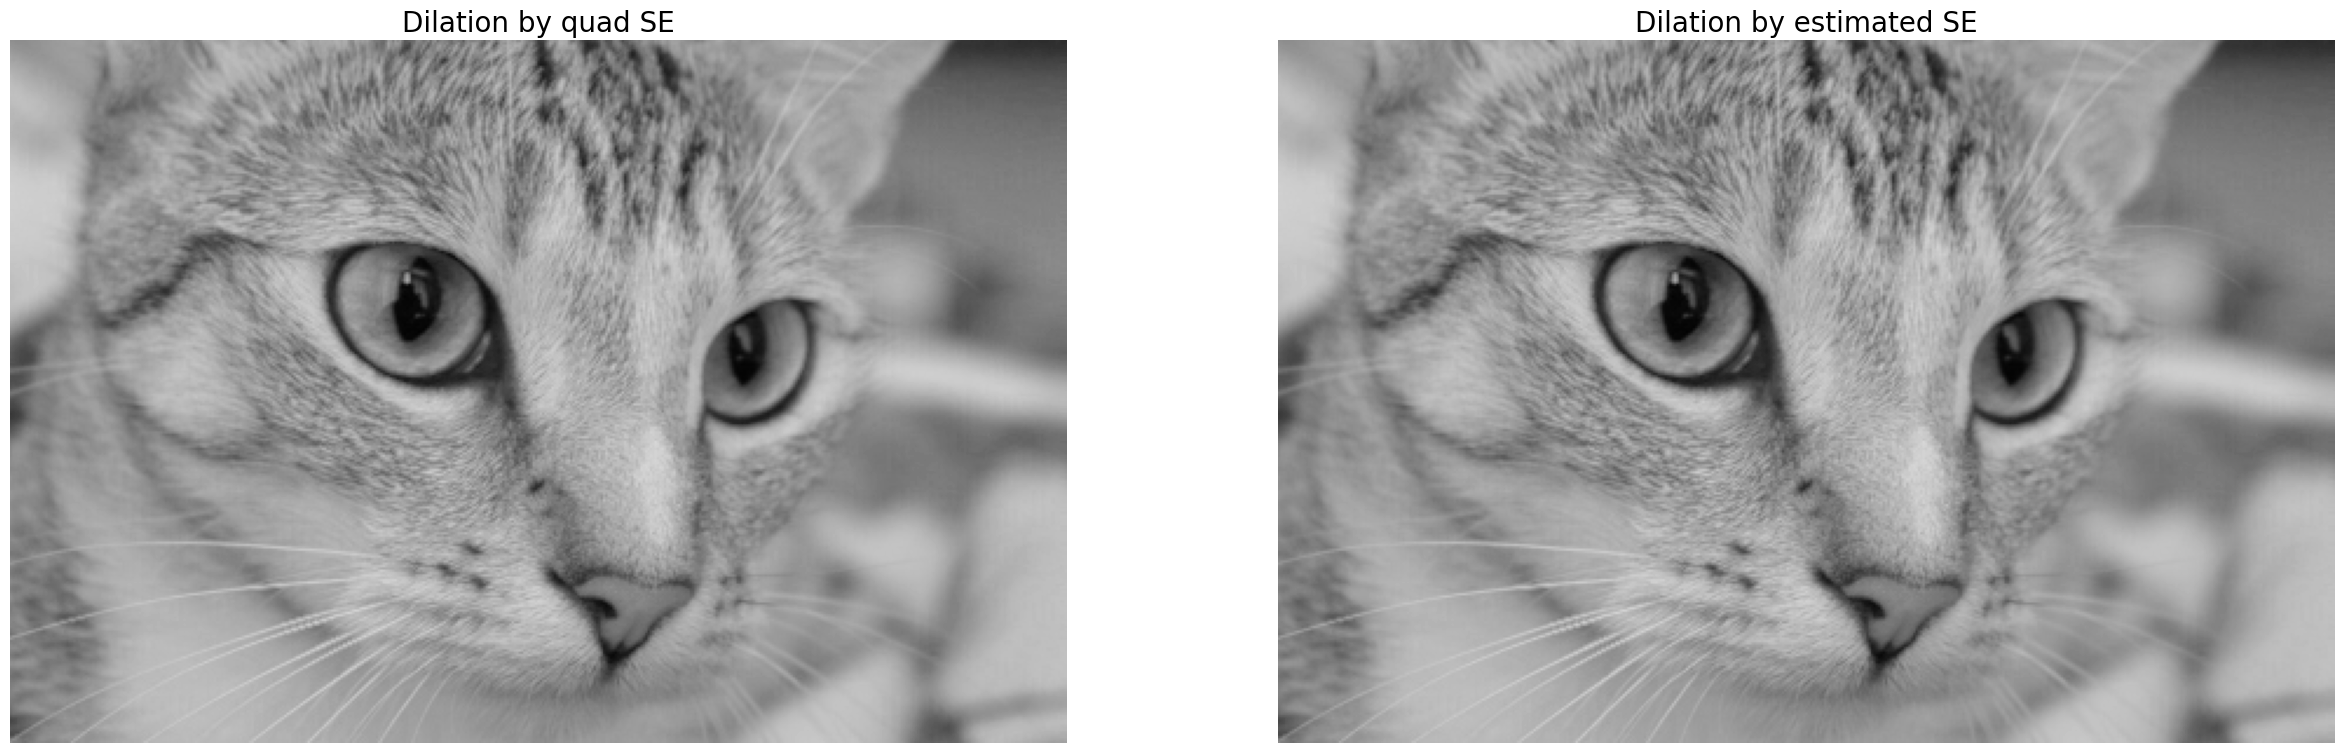

In [20]:
plt.figure(figsize=(30,12))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(catDil, cmap='gray', vmin=0, vmax=255)
plt.title('Dilation by '+SE_id+' SE', fontsize=20)
plt.subplot(1,2,2)
plt.imshow(catDilEstSE, cmap='gray', vmin=0, vmax=255)
plt.title('Dilation by estimated SE', fontsize=20)
plt.axis('off')
plt.show()

Compute the mean squared error between original and estimated dilation:

In [21]:
errEst = np.sum((catDil - catDilEstSE)**2)
print(errEst)

0.0


## Learning a dilation structuring element by error minization with gradient descent

Load Fashion MNIST images.

In [3]:
# input image dimensions
img_rows, img_cols = 28, 28
num_classes = 10

# the data, split between train and test sets

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
#(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)

4422102/4422102 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)


Define a $7\times 7$ quadratic structuring element.

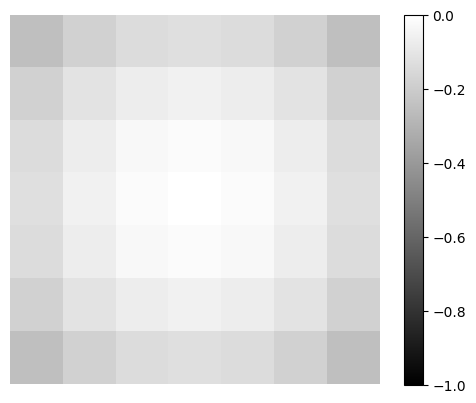

In [22]:
p = 3
SE_id = 'quad'#'diag2' #'diag1' #'x-shaped' # cross #'half_cross' #'quad'
SE = mkSE(p, SE_id)/255
plt.figure()
plt.imshow(SE,cmap='gray',vmax=0,vmin=-1)
plt.colorbar()
plt.axis('off')
plt.show()

Show examples of dilation results.

Examples from the training set:


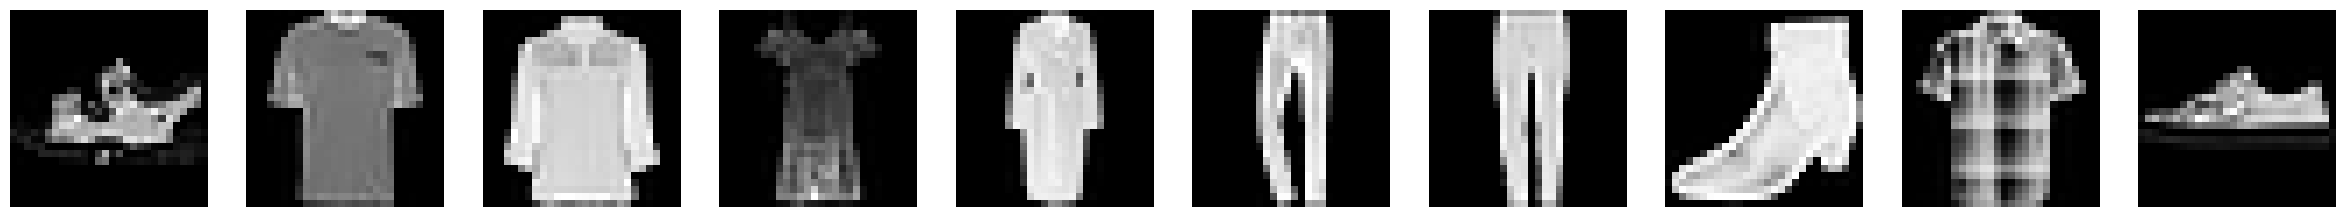

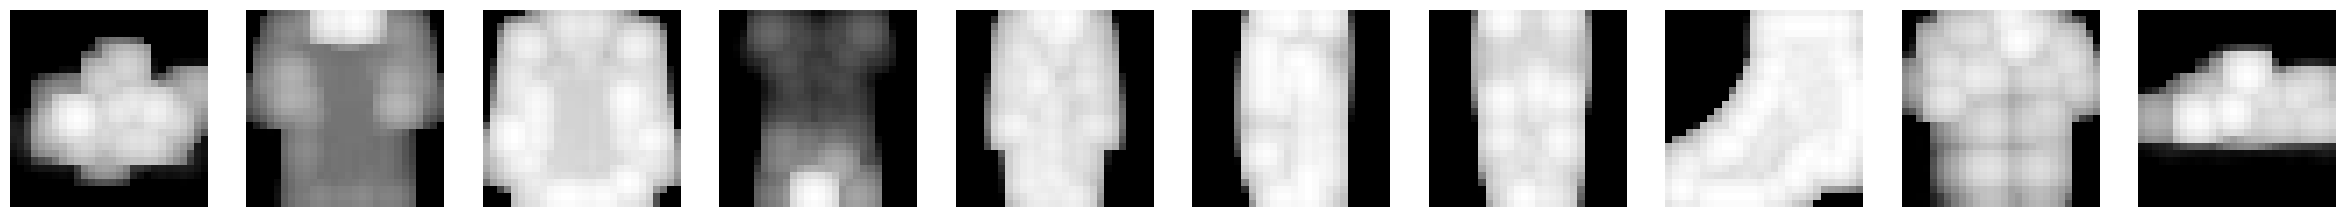

In [23]:
print('Examples from the training set:')
nsamp = 10
plt.figure(figsize=(30, 5))
ridxs = []
for i in range(nsamp):
    plt.subplot(1,nsamp,i+1)
    randidx = np.random.randint(x_train.shape[0])
    ridxs.append(randidx)
    plt.imshow(x_train[randidx,:,:,0],vmin=0, vmax=1, cmap ='gray')
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 5))
for i in range(nsamp):
    plt.subplot(1,nsamp,i+1)
    imdil = DilMaxPlus(x_train[ridxs[i],:,:,0], SE)
    plt.imshow(imdil,vmin=0, vmax=1, cmap ='gray')
    plt.axis('off')
plt.show()

Split images into train and test sets.

In [24]:
ntrain = 150
randidxs = np.random.randint(x_train.shape[0], size=(ntrain,))
Xtrain = x_train[randidxs, :, :, :]
ntest = 50
randidxs = np.random.randint(x_test.shape[0], size=(ntest,))
Xtest = x_test[randidxs, :, :, :]

In [25]:
print(Xtrain.shape)
print(Xtest.shape)

(150, 28, 28, 1)
(50, 28, 28, 1)


Create ground truth labelling (by dilating train and test images).

In [26]:
Ytrain = np.zeros(Xtrain.shape)
for i in range(ntrain):
    Ytrain[i, :, :, 0] =  DilMaxPlus(Xtrain[i,:,:,0], SE)
Ytest = np.zeros(Xtest.shape)
for i in range(ntest):
    Ytest[i, :, :, 0] =  DilMaxPlus(Xtest[i,:,:,0], SE)

Define the dilation neural network containing one dilation layer.

In [27]:
inputIm = Input(shape=input_shape)
xout = Dilation2D(1,kernel_size=(2*p+1,2*p+1),padding='same',strides=(1,1))(inputIm)
modelDilation=Model(inputIm,xout, name='dilationModel')
modelDilation.summary()

Model: "dilationModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 dilation2d (Dilation2D)     (None, 28, 28, 1)         49        
                                                                 
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


Set optimization parameters.

In [28]:
modelDilation.compile(loss=tensorflow.keras.losses.mse,
          optimizer=tensorflow.keras.optimizers.Adam(),
          metrics=['mse'])

In [29]:
#filecsv='LearningCurvesMorphoModel_fashion.txt'
#cb=CSVLogger(filecsv,append=False)
earlyStop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=20, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

Start training!

In [30]:
modelDilation.fit(Xtrain, Ytrain,
          batch_size=10,
          epochs=200,
          verbose=1,
          validation_data=(Xtest, Ytest), callbacks = [earlyStop])

Epoch 1/200
15/15 [==============================] - 5s 21ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 2/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 3/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 4/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 5/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 6/200
15/15 [==============================] - 0s 7ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 7/200
15/15 [==============================] - 0s 6ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 8/200
15/15 [==============================] - 0s 7ms/step - loss: 0.0020 - 

Monitor the weights of the dilation layer (that is, the learned structuring element).

In [31]:
W = modelDilation.get_weights()[0] # Get the weights of the only layer in modelMorpho
print(W.shape)
print(W[:,:,0,0])

(7, 7, 1, 1)
[[-2.3175663e-01 -1.7833665e-01 -1.3725370e-01 -1.2549019e-01
  -1.3725205e-01 -1.7878187e-01 -2.3281687e-01]
 [-1.7886196e-01 -1.0980389e-01 -7.0588246e-02 -5.4901958e-02
  -7.0588253e-02 -1.0980390e-01 -1.7902157e-01]
 [-1.3725382e-01 -7.0588253e-02 -2.7450979e-02 -1.5686274e-02
  -2.7450975e-02 -7.0588246e-02 -1.3725376e-01]
 [-1.2549016e-01 -5.4901931e-02 -1.5686277e-02  1.1404808e-11
  -1.5686277e-02 -5.4901939e-02 -1.2549019e-01]
 [-1.3725482e-01 -7.0588216e-02 -2.7450992e-02 -1.5686279e-02
  -2.7450992e-02 -7.0588216e-02 -1.3725482e-01]
 [-1.7944671e-01 -1.0980389e-01 -7.0588261e-02 -5.4901946e-02
  -7.0588261e-02 -1.0980396e-01 -1.7987315e-01]
 [-2.3541373e-01 -1.7806539e-01 -1.3723084e-01 -1.2548974e-01
  -1.3723949e-01 -1.7907053e-01 -2.3855996e-01]]


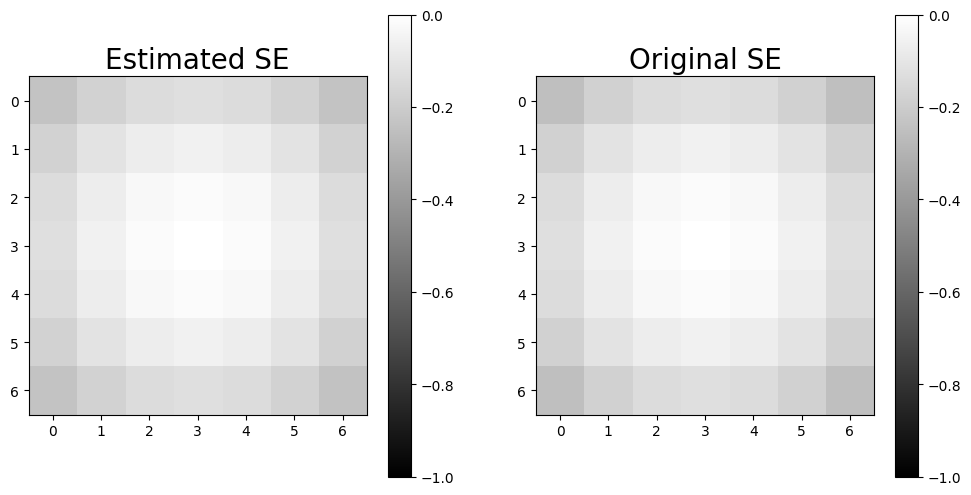

In [32]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(W[:,:,0,0], cmap = 'gray',vmax=0,vmin=-1)
plt.title('Estimated SE', fontsize=20)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(SE,cmap='gray',vmax=0,vmin=-1)
plt.title('Original SE', fontsize=20)
plt.colorbar()
plt.show()

## Learning an opening structuring element by error minization by gradient descent

The functions ErodMinPlus and OpenMaxPlus are analogous to DilMaxPlus: the do the reshaping and apply the proper max/min-plus operators.

In [33]:
def ErodMinPlus(im_input, SE):
    M =im_input.shape[0]
    N =im_input.shape[1]
    p = int((SE.shape[0]-1)/2)
    SECol = np.reshape(SE, ((2*p+1)**2,1))
    imBlock = block_reshape(im_input, p)
    resColumn = erod_min_plus(imBlock, -SECol)
    im_res = np.reshape(np.transpose(resColumn), (M, N), 'F')
    return im_res

In [34]:
def OpenMaxPlus(im_input, SE):
    imEro = ErodMinPlus(im_input, SE)
    im_res = DilMaxPlus(imEro, SE)
    return im_res

Show chosen structring element (try symmetric and non symmetric SEs).

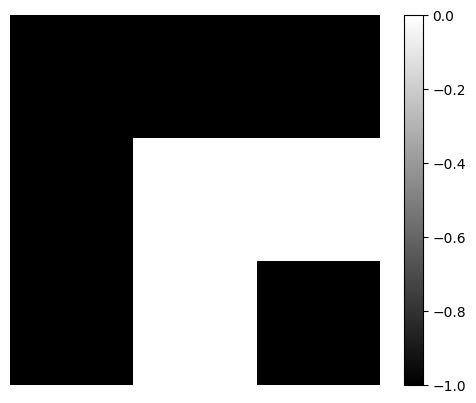

In [35]:
p = 1
SE_id = 'half_cross'#'diag2' #'diag1' #'x-shaped' # cross #'half_cross' #'quad'
SE = mkSE(p, SE_id)/255
plt.figure()
plt.imshow(SE,cmap='gray',vmax=0,vmin=-1)
plt.colorbar()
plt.axis('off')
plt.show()

Show examples of opening.

Examples from the training set:


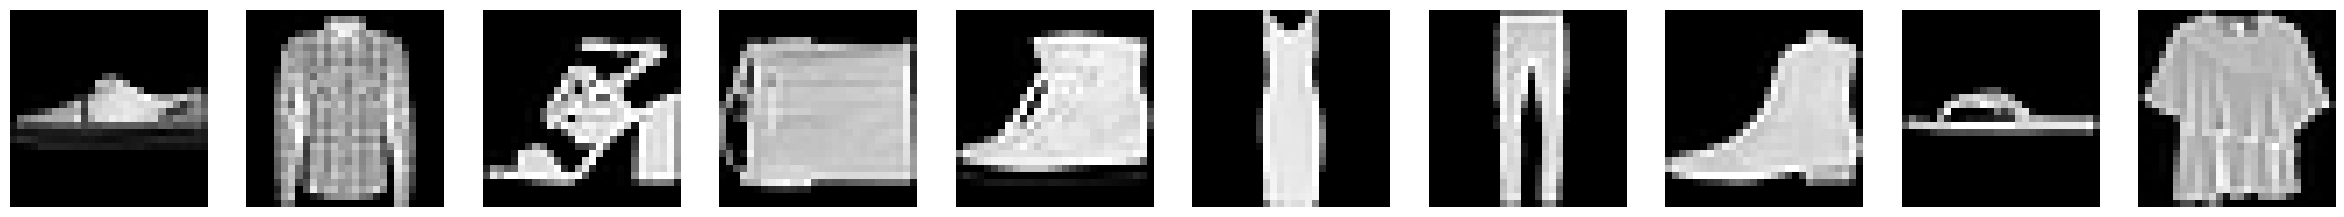

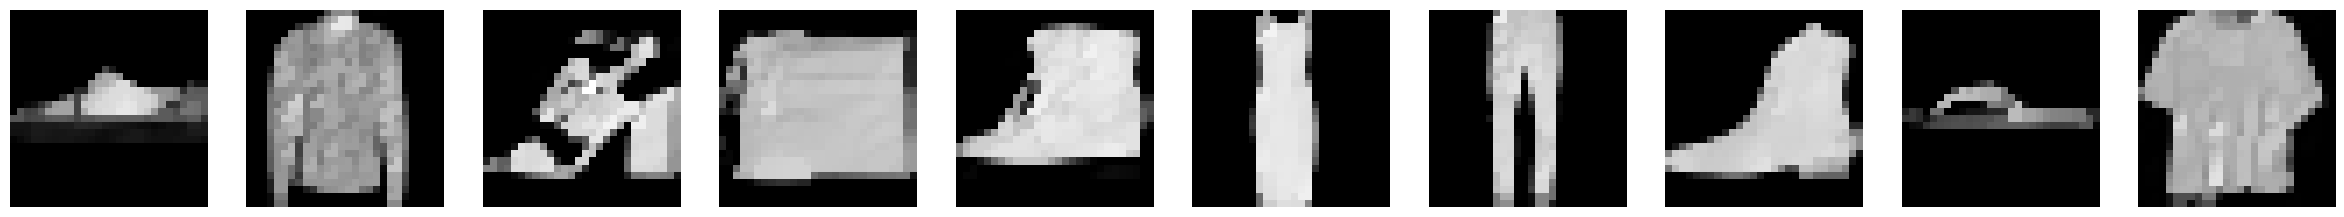

In [36]:
print('Examples from the training set:')
nsamp = 10
plt.figure(figsize=(30, 5))
ridxs = []
for i in range(nsamp):
    plt.subplot(1,nsamp,i+1)
    randidx = np.random.randint(x_train.shape[0])
    ridxs.append(randidx)
    plt.imshow(x_train[randidx,:,:,0],vmin=0, vmax=1, cmap ='gray')
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 5))
for i in range(nsamp):
    plt.subplot(1,nsamp,i+1)
    imopen = OpenMaxPlus(x_train[ridxs[i],:,:,0], SE)
    plt.imshow(imopen,vmin=0, vmax=1, cmap ='gray')
    plt.axis('off')
plt.show()

Split into train and test sets.

In [37]:
ntrain = 500 #150
randidxs = np.random.randint(x_train.shape[0], size=(ntrain,))
Xtrain = x_train[randidxs, :, :, :]
ntest = 100 #50
randidxs = np.random.randint(x_test.shape[0], size=(ntest,))
Xtest = x_test[randidxs, :, :, :]

Ground truth labelling.

In [38]:
Ytrain = np.zeros(Xtrain.shape)
for i in range(ntrain):
    Ytrain[i, :, :, 0] =  OpenMaxPlus(Xtrain[i,:,:,0], SE)
Ytest = np.zeros(Xtest.shape)
for i in range(ntest):
    Ytest[i, :, :, 0] =  OpenMaxPlus(Xtest[i,:,:,0], SE)

Define a "one layer opening" architecture.

In [39]:
inputIm = Input(shape=input_shape)
xout = Opening2D(1,kernel_size=(2*p+1,2*p+1),padding='same',strides=(1,1),kernel_constraint=NonPositiveExtensive())(inputIm)
modelOpen=Model(inputIm,xout, name = 'openingWrapped')
modelOpen.summary()

Model: "openingWrapped"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 opening2d (Opening2D)       (None, 28, 28, 1)         9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [40]:
modelOpen.compile(loss=tensorflow.keras.losses.mse,
          optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00001),
          metrics=['mse'])

In [41]:
earlyStop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=200, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

Start training!

In [43]:
modelOpen.fit(Xtrain, Ytrain,
          batch_size=10,
          epochs=150,
          verbose=1,
          validation_data=(Xtest, Ytest), callbacks = [earlyStop])

Epoch 1/150
50/50 [==============================] - 0s 7ms/step - loss: 0.0316 - mse: 0.0316 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 2/150
50/50 [==============================] - 0s 6ms/step - loss: 0.0316 - mse: 0.0316 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 3/150
50/50 [==============================] - 0s 7ms/step - loss: 0.0316 - mse: 0.0316 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 4/150
50/50 [==============================] - 0s 7ms/step - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 5/150
50/50 [==============================] - 1s 10ms/step - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 6/150
50/50 [==============================] - 1s 11ms/step - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 7/150
50/50 [==============================] - 0s 10ms/step - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 8/150
50/50 [==============================] - 0s 8ms/step - loss: 0.0315 

Monitor the learned weights (the structuring element).

In [44]:
W = modelOpen.get_weights()[0] # Get the weights of the only layer in modelMorpho
print(W.shape)
print(W[:,:,0,0])

(3, 3, 1, 1)
[[-3.8700495e-02 -4.9189851e-02 -9.4237760e-02]
 [-9.4352826e-02  0.0000000e+00 -3.7926977e-06]
 [-1.0100385e-01 -7.3415428e-08  0.0000000e+00]]


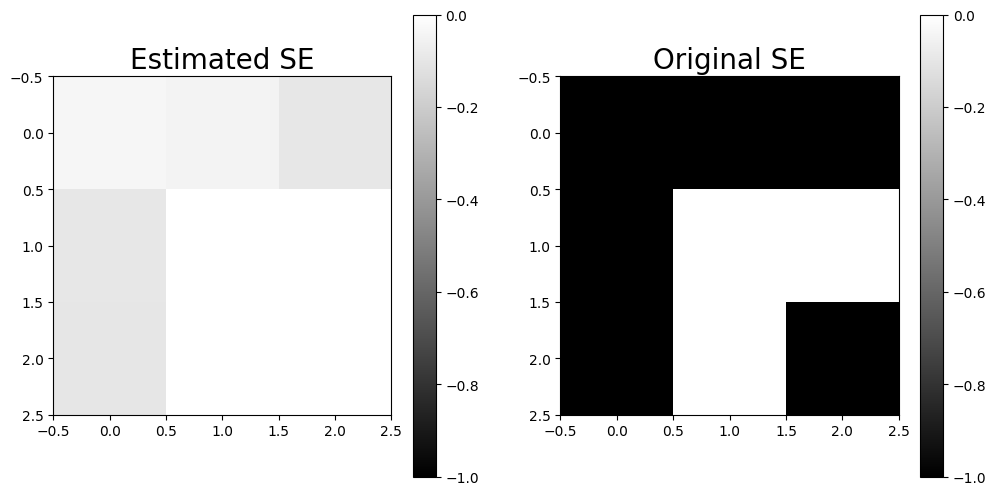

In [45]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(W[:,:,0,0], cmap = 'gray',vmax=0,vmin=-1)
plt.title('Estimated SE', fontsize=20)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(SE,cmap='gray',vmax=0,vmin=-1)
plt.title('Original SE', fontsize=20)
plt.colorbar()
plt.show()

Now define a "two layers" opening architecture.

In [46]:
inputIm = Input(shape=input_shape)
xero = Erosion2D(1,kernel_size=(2*p+1,2*p+1),padding='same',strides=(1,1),kernel_constraint=NonPositiveExtensive(),name='myErosion')(inputIm)
xout = Dilation2D(1,kernel_size=(2*p+1,2*p+1),padding='same',strides=(1,1),kernel_constraint=NonPositiveExtensive(), name='myDilation')(xero)
modelOpen2=Model(inputIm,xout, name='OpeningSequential')
modelOpen2.summary()

Model: "OpeningSequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 myErosion (Erosion2D)       (None, 28, 28, 1)         9         
                                                                 
 myDilation (Dilation2D)     (None, 28, 28, 1)         9         
                                                                 
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________


In [47]:
modelOpen2.compile(loss=tensorflow.keras.losses.mse,
          optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0001),
          metrics=['mse'])

In [48]:
earlyStop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=100, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

In [49]:
modelOpen2.fit(Xtrain, Ytrain,
          batch_size=10,
          epochs=150,
          verbose=1,
          validation_data=(Xtest, Ytest), callbacks = [earlyStop])

Epoch 1/150
50/50 [==============================] - 2s 10ms/step - loss: 0.0318 - mse: 0.0318 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 2/150
50/50 [==============================] - 0s 6ms/step - loss: 0.0314 - mse: 0.0314 - val_loss: 0.0311 - val_mse: 0.0311
Epoch 3/150
50/50 [==============================] - 0s 5ms/step - loss: 0.0309 - mse: 0.0309 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 4/150
50/50 [==============================] - 0s 7ms/step - loss: 0.0304 - mse: 0.0304 - val_loss: 0.0302 - val_mse: 0.0302
Epoch 5/150
50/50 [==============================] - 0s 3ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0298 - val_mse: 0.0298
Epoch 6/150
50/50 [==============================] - 0s 3ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0293 - val_mse: 0.0293
Epoch 7/150
50/50 [==============================] - 0s 3ms/step - loss: 0.0291 - mse: 0.0291 - val_loss: 0.0288 - val_mse: 0.0288
Epoch 8/150
50/50 [==============================] - 0s 3ms/step - loss: 0.0286 - 

Monitor the weights of each layer.

In [50]:
L1 = modelOpen2.get_layer('myErosion')
L2 = modelOpen2.get_layer('myDilation')
W1 = L1.get_weights()[0]
W2 = L2.get_weights()[0]
print(W1.shape)
print(W2.shape)

(3, 3, 1, 1)
(3, 3, 1, 1)


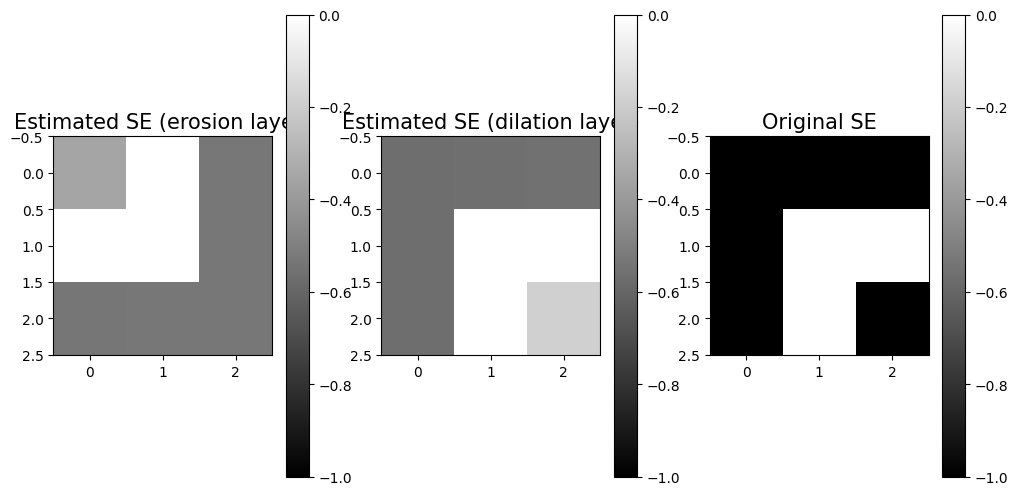

In [51]:
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(W1[:,:,0,0], cmap = 'gray',vmax=0,vmin=-1)
plt.title('Estimated SE (erosion layer)', fontsize=15)
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(W2[:,:,0,0], cmap = 'gray',vmax=0,vmin=-1)
plt.title('Estimated SE (dilation layer)', fontsize=15)
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(SE,cmap='gray',vmax=0,vmin=-1)
plt.title('Original SE', fontsize=15)
plt.colorbar()
plt.show()